<a href="https://colab.research.google.com/github/masadeghi/EHRsample/blob/main/hospitalization_duration_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import the data from your Google drive account:**

After running the first cell, you'll need to authorize access to your Drive.

In [4]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
!unzip gdrive/MyDrive/Databases/proj2.zip

Archive:  gdrive/MyDrive/Databases/proj2.zip
  inflating: hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.3/LICENSE.txt  
  inflating: hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.3/SHA256SUMS.txt  
  inflating: hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.3/dat.csv  
  inflating: hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.3/dat_md.csv  
  inflating: hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.3/dataDictionary.csv  


In [6]:
import pandas as pd

heart_data = pd.read_csv('/content/hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.3/dat.csv')
md_data = pd.read_csv('/content/hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.3/dat_md.csv')
dict_data = pd.read_csv('/content/hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.3/dataDictionary.csv')

Explore the variables in the main dataset to classify them into the following categories:


*   Variables that are expected to be available at the time of admission or a short while after (e.g., preliminary lab data)
*   Variables that are expected to be available only at the time of discharge
*   Variables from echocardiography
*   Variables that are expected to be available only after patient discharge and on patient follow-up




In [ ]:
# dict_data contains explanations for each feature in the dataset
"""
%load_ext google.colab.data_table
dict_data
"""

In [8]:
# Variables availble at the time of discharge, including duration of hospital stay
discharge_var = [1, 5, 53, 164]

# Variables only available after discharge and on patient follow-up
future_var = list(range(54,64))

# Variables from an echocardiography
echo_var = list(range(46,53))

Transform the dat_md dataset to represent drug administration using one-hot encoding. Each row will indicate a unique patient (`inpatient.number`) and each column will indicating a unique drug. The transformed dataset can then be concatenated with the main dataset.

In [ ]:
"""
print('md_data dimensions: ', md_data.shape)
%reload_ext google.colab.data_table
md_data
"""

In [10]:
# One-hot encoding drug administrations
import numpy as np

# Initialize zeros matrix with desired dimensions, indexes, and column names
drugs = np.zeros((len(heart_data['inpatient.number'].unique()),
                  len(md_data['Drug_name'].unique())))

drugs = pd.DataFrame(drugs, index = heart_data['inpatient.number'].unique(), columns = md_data['Drug_name'].unique())

# Iterate over the rows and columns of the constructed matrix and repalce 0 with 1
# in the appropriate column if the treatment was administered.
for index, row in drugs.iterrows():
  for col in drugs.columns:
    subset = md_data.loc[md_data['inpatient.number'] == index, 'Drug_name']
    if col in subset.values:
      drugs.loc[index, col] = 1

# Concatenate the resulting matrix the main dataset:
# Total data (t_data) = main dataset + drug data
heart_data.set_index('inpatient.number', inplace = True)

t_data = pd.concat([heart_data, drugs], axis = 1)

Identify features with missing data and explore each variable to get a better feel for the data.

In [11]:
# Percentage of missing data in each column (if present)
for i, col in enumerate(t_data.columns):
  if t_data[col].isnull().mean() > 0:
    print(f'{i, col}:', "%.2f" % t_data[col].isnull().mean())

(4, 'occupation'): 0.01
(27, 'peptic.ulcer.disease'): 0.00
(29, 'moderate.to.severe.chronic.kidney.disease'): 0.00
(34, 'liver.disease'): 0.00
(36, 'CCI.score'): 0.00
(46, 'LVEF'): 0.68
(47, 'left.ventricular.end.diastolic.diameter.LV'): 0.35
(48, 'mitral.valve.EMS'): 0.51
(49, 'mitral.valve.AMS'): 0.73
(50, 'EA'): 0.80
(51, 'tricuspid.valve.return.velocity'): 0.61
(52, 'tricuspid.valve.return.pressure'): 0.91
(60, 'time.of.death..days.from.admission.'): 0.98
(61, 're.admission.time..days.from.admission.'): 0.55
(62, 'return.to.emergency.department.within.6.months'): 0.00
(63, 'time.to.emergency.department.within.6.months'): 0.55
(64, 'creatinine.enzymatic.method'): 0.01
(65, 'urea'): 0.01
(66, 'uric.acid'): 0.01
(67, 'glomerular.filtration.rate'): 0.03
(68, 'cystatin'): 0.02
(69, 'white.blood.cell'): 0.01
(70, 'monocyte.ratio'): 0.01
(71, 'monocyte.count'): 0.01
(72, 'red.blood.cell'): 0.01
(73, 'coefficient.of.variation.of.red.blood.cell.distribution.width'): 0.01
(74, 'standard.devi

In [12]:
# You could use the following function for quick exploration of each variable
def summary(colname):
  col = t_data[colname]

  print(col[:10])

  if col.dtype == object:
    print('\n Unique factors: \n', col.unique())
    print('\n', col.describe(include = 'object'))
  else:
    print('\n', col.describe())

# **Prepare data for building the models**

**Step 1:** 

*   Separate data into predictor (X) and target (y) data.
*   Remove discharge and future variables from X
*   Remove variables with more than 30% missing values from X (echo variables are removed as a result).
*   log transform y because it is right skewed

In [13]:
# Remove discharge and future variables
y = t_data['dischargeDay']
X = t_data.drop(t_data.columns[discharge_var + future_var], axis = 1) # dischargeDay is within discharge_var

# Remove variables with more than 30% missing data
keepers = [True] * len(X.columns)

for i, col in enumerate(X.columns):
  if X[col].isnull().mean() > 0.3:
    keepers[i] = False

X = X.loc[:, keepers]

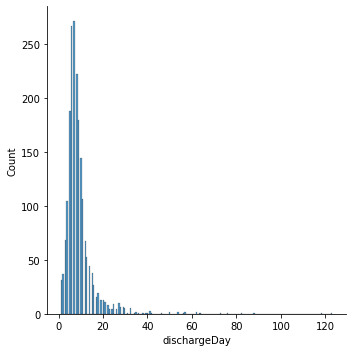

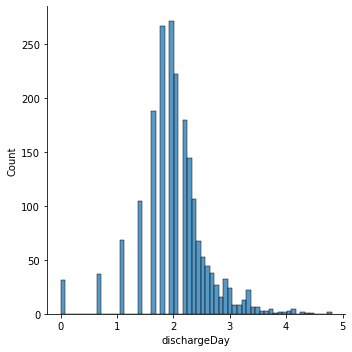

In [14]:
# log transform y
import seaborn as sns
sns.displot(y)
y = np.log(y)
sns.displot(y)

**Step 2:**
One-hot encode the categorical variables in the dataset.

In [15]:
import numpy as np

# Replace NAs with mode in the categorical (dtype = 'object') variables.
# occupation is the only categorical variable with missing values
value = X['occupation'].mode()[0]
X['occupation'].replace(np.nan, value, inplace = True)

# OneHotencoding
from sklearn.preprocessing import OneHotEncoder

X_obj = X.select_dtypes(include = ['object']).copy()
enc = OneHotEncoder(sparse = False) #sparse = False to enable concatenation with the noncategorical variables.
X_obj_enc = enc.fit_transform(X_obj)
X_obj_enc = pd.DataFrame(X_obj_enc, columns = enc.get_feature_names_out(), index = X.index)

#Replace object variables with the onehot encoded version in the original dataset
X.drop(X_obj.columns,
       axis = 1,
       inplace = True)

X = pd.concat([X_obj_enc, X], axis = 1)

**Step 3:**
*   Split the data into train and test groups
*   Impute missing values using a KNN imputer
*   Standard scale the variables that aren't one-hot encoded (since we will use svm and linear regression models).

Imputations and scaling for the test data are performed based on the train group fit to prevent leakage.

In [16]:
# Split the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Save indices for future data modificatons
train_indices = X_train.index
test_indices = X_test.index

In [17]:
# Impute missing values using the KNN imputer
from sklearn.impute import KNNImputer

imp = KNNImputer()

X_train = imp.fit_transform(X_train)
X_test = imp.transform(X_test)

In [18]:
# Removing one-hot encoded variables from scaling
X_train = pd.DataFrame(X_train, index = train_indices, columns = X.columns)
X_test = pd.DataFrame(X_test, index = test_indices, columns = X.columns)

non_one_hot = [col for col in X_train.columns if len(X_train[col].unique()) != 2]

X_train_non_hot = X_train.loc[:, non_one_hot]
X_train_hot = X_train.drop(non_one_hot, axis = 1)

X_test_non_hot = X_test.loc[:, non_one_hot]
X_test_hot = X_test.drop(non_one_hot, axis = 1)

In [19]:
# Standard scale the non-encoded variables
# Concatenate the resulting dataframe with the rest of the data.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_non_hot_scaled = scaler.fit_transform(X_train_non_hot)
X_train_non_hot_scaled = pd.DataFrame(X_train_non_hot_scaled, index = X_train_non_hot.index, columns = X_train_non_hot.columns)
X_train = pd.concat([X_train_non_hot_scaled, X_train_hot], axis = 1)

X_test_non_hot_scaled = scaler.transform(X_test_non_hot)
X_test_non_hot_scaled = pd.DataFrame(X_test_non_hot_scaled, index = X_test_non_hot.index, columns = X_test_non_hot.columns)
X_test = pd.concat([X_test_non_hot_scaled, X_test_hot], axis = 1)

# **Build random forest model for prediction of hospitalization duration**

**Base model:**

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

nl_reg = RandomForestRegressor()

nl_reg.fit(X_train, y_train)

y_pred = nl_reg.predict(X_test)

mean_squared_error(y_test, y_pred)

0.26340461484817573

**Tune hyperparameters using grid search cross-validation:**

The code cell is commented out as it did not improve model performance while being computationally time-consuming.

In [ ]:
# Hyperparameter tuning using grid search
"""
from sklearn.model_selection import GridSearchCV

grd_reg = RandomForestRegressor()

param_grid = {'max_depth': [30, 40, 50],
               'n_estimators': [150, 200, 250]}

grd_reg = GridSearchCV(estimator = grd_reg, param_grid = param_grid, 
                               cv = 5, verbose = 3, n_jobs = -1, scoring = 'neg_mean_squared_error')

grd_reg.fit(X_train, y_train)

print('\nBest estimator: \n', grd_reg.best_estimator_)
print('\nBest score: \n', grd_reg.best_score_)
print('\nBest parameters: \n', grd_reg.best_params_)

y_pred = grd_reg.best_estimator_.predict(X_test)

print('\nMSE on test data: ', mean_squared_error(y_test, y_pred))
"""

**Tune hyperparameters using randomized search cross-validation:**

The code cell is commented out as it did not improve model performance while being computationally time-consuming.

In [ ]:
# Hyperparameter tuning using randomized search (the main differentiator from
# the previous cell is the max_features hyperparameter)
"""
from sklearn.model_selection import RandomizedSearchCV

rnd_reg = RandomForestRegressor()

random_grid = {'max_depth': [2, 16, 32, 64, None],
               'n_estimators': [64, 256, 512],
               'max_features': ['sqrt', 0.2, 'auto']}

rnd_reg = RandomizedSearchCV(estimator = rnd_reg, param_distributions = random_grid, 
                               cv = 5, verbose = 3, n_jobs = -1, random_state = 42, scoring = 'neg_mean_squared_error')

rnd_reg.fit(X_train, y_train)

print('\nBest estimator \n', rnd_reg.best_estimator_)
print('\nBest score \n', rnd_reg.best_score_)
print('\nBest parameters \n', rnd_reg.best_params_)

y_pred = rnd_re.best_estimator_.predict(X_test)

print('\nMSE on test data:', mean_squared_error(y_test, y_pred))
"""

**Extract feature importances:**

In [21]:
forest_importance = pd.Series(nl_reg.feature_importances_,
                              index = X_train.columns).sort_values(ascending = False)

forest_importance[:10]

Torasemide tablet                  0.037065
Furosemide tablet                  0.035587
carbon.dioxide.binding.capacity    0.025066
cystatin                           0.024320
creatine.kinase.isoenzyme          0.018745
chloride                           0.018652
uric.acid                          0.018447
urea                               0.018395
platelet                           0.017509
total.protein                      0.016943
dtype: float64

# **Build regularized linear regression model for prediction of hospitalization duration**

In [26]:
# Suppress convergence warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Regularized linear model
from sklearn.linear_model import ElasticNetCV

lin_reg = ElasticNetCV(l1_ratio = [0, 0.2, 0.5, 0.8, 0.9, 0.95, 0.99, 1],
                       alphas = [0, 0.1, 0.2, 0.5, 0.7, 0.9, 1])

lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)

print('MSE for lin_reg is: ', mean_squared_error(y_test, y_pred))
print('\nChosen l1-ratio: ', lin_reg.l1_ratio_)
print('\nChosen alpha: ', lin_reg.alpha_)

MSE for lin_reg is:  0.2699469963032169

Chosen l1-ratio:  0.0

Chosen alpha:  0.1


# **Build support vector regressor for prediction of hospitalization duration**

In [ ]:
# If you don't want to run the grid search, you could use the following parameters:
# C = 0.1, gamma = 1, kernel = linear (next cell)

"""
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

sv_reg = SVR()

param_grid = {'kernel' : ['linear', 'rbf', 'poly'],
              'gamma' : [0.2, 0.5, 1, 5],
              'C' : [0.1, 1, 10, 30]}

sv_reg = GridSearchCV(sv_reg, param_grid = param_grid, 
                              verbose = 3, cv = 5, scoring = 'neg_mean_squared_error')

sv_reg.fit(X_train, y_train)

print('\nBest estimator: \n', sv_reg.best_estimator_)
print('\nBest score: \n', sv_reg.best_score_)
print('\nBest parameters: \n', sv_reg.best_params_)

y_pred = sv_reg.best_estimator_.predict(X_test)

print('\nMSE on test data: ', mean_squared_error(y_test, y_pred))
"""

In [30]:
# SVR using the optimum parameters
from sklearn.svm import SVR

sv_reg = SVR(kernel = 'linear', gamma = 1, C = 0.1)

sv_reg.fit(X_train, y_train)

y_pred = sv_reg.predict(X_test)

mean_squared_error(y_test, y_pred)

0.26978063980952033

# **Build super ensemble (voting regressor) model**

In [31]:
from sklearn.ensemble import VotingRegressor

vote_reg = VotingRegressor(estimators = [('rf', nl_reg), ('lin', lin_reg), ('svr', sv_reg)])

vote_reg.fit(X_train, y_train)

y_pred = vote_reg.predict(X_test)

mean_squared_error(y_test, y_pred)

0.25587761618511057